In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import yaml
import os
from networkx.algorithms import approximation as nx_approx
from tqdm.notebook import tqdm
from copy import deepcopy
# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'
import scipy.stats
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history
from contagion.pdfs import construct_pdf
from distributed import Client
import itertools
from matplotlib.backends.backend_pdf import PdfPages

In [29]:
cpp_config = {
    "DaysBackwardTrace": 7, 
    "TestPositiveProbability": 0.9, 
    "OutputPrefix": "CovidMC_1346", 
    "AppProbability": 0, 
    "DaysToTestResult": 0, 
    "FalsePositiveRate": 0.00, 
    "NDays": 500, 
    "SymptomProbability": 0.2, 
    "SocialDistancingFactor": 1.0, 
    "SocialDistancingTo": 99999, 
    "BackwardTracing": True, 
    "dTTest": 5, 
    "PeopleMetPerDay": 10.35, 
    "DaysInQuarantine": 14, 
    "TraceUninfected": True, 
    "AsymptomaticTransmissionScaling": 1.0, 
    "StartTracingTestingInfectedFraction": 0, 
    "SocialDistancingFrom": 99999, 
    "TransmissionProbability": 0.0287, 
    "NPersons": 990, 
    "TracingOrder": 1, 
    "IncubationPeriod": {
        "mu": 0, 
        "beta": 2.44, 
        "gamma": 3.06
    }, 
    "TestThreshold": 0.01, 
    "tracingEfficiency": 1.0, 
    "SocialDistancingMaxPeople": 60, 
    "Infectivity": {
        "mu": -2.42, 
        "beta": 1.56, 
        "gamma": 2.08
    }, 
    "TracingDelay": 0, 
    "ReportingProbability": 1.0
}
incub_pdf = scipy.stats.gamma(cpp_config["IncubationPeriod"]["gamma"], scale=cpp_config["IncubationPeriod"]["beta"])
infect_pdf = scipy.stats.gamma(
    cpp_config["Infectivity"]["gamma"],
    scale=cpp_config["Infectivity"]["beta"],
    )

ppl_met_per_day_pdf = scipy.stats.gamma(2, scale=cpp_config["PeopleMetPerDay"]/2)

In [30]:
my_config = dict(_baseconfig)

my_config["general"]["random state seed"] = 6
my_config["general"]["track graph history"] = True
my_config["general"]["debug level"] = 50
my_config["general"]["trace spread"] = True

my_config["population"]["social circle interactions pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["social circle pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}



my_config["measures"]["contact tracing"] = True
my_config["measures"]["tracked fraction"] = 0 #cpp_config["AppProbability"]
my_config["measures"]["second order"] = cpp_config["TracingOrder"] == 2
my_config["measures"]["backtrack length"] = cpp_config["DaysBackwardTrace"]+1
my_config["measures"]["track uninfected"] = cpp_config["TraceUninfected"]
my_config["measures"]["quarantine"] = True
my_config["measures"]["report symptomatic"] = True
my_config["measures"]["quarantine duration"] = cpp_config["DaysInQuarantine"]
my_config["measures"]["testing"] = True
my_config["measures"]["time until test"] = 0
my_config["measures"]["time until result"] = cpp_config["DaysToTestResult"]
my_config["measures"]["time until second test"] = cpp_config["dTTest"]+1
my_config["measures"]["time until second test result"] = 0
my_config["measures"]["test true positive rate"] = cpp_config["TestPositiveProbability"]
my_config["measures"]["test false positive rate"] = cpp_config["FalsePositiveRate"]
my_config["measures"]["test threshold"] = cpp_config["TestThreshold"]
my_config["measures"]["app fraction"] = cpp_config["AppProbability"]

my_config["scenario"]["sim_length"] = 500
my_config['infection']['infected'] = 1
my_config["infection"]["infection probability pdf"] = {
    "class": "Gamma",
    "scaling": (infect_pdf.ppf(0.99))*cpp_config["TransmissionProbability"],
    "mean":  infect_pdf.mean(),
    "sd":  infect_pdf.std()
}
my_config['infection']["hospitalization probability pdf"] = {
    'mean':  0,
    "class": "Delta"
}
my_config['infection']['will have symptoms prob pdf'] = {
    'mean': cpp_config["SymptomProbability"],
    "class": "Delta"
}


my_config["infection"]["infectious duration pdf"] = {
    "mean": np.round(infect_pdf.ppf(0.99))-cpp_config["Infectivity"]["mu"],
    "class": "Delta"
}

my_config["infection"]["latency duration pdf"] = {
    #"mean": -cpp_config["Infectivity"]["mu"],
    #"class": "Delta"
    "upper": -cpp_config["Infectivity"]["mu"]+1,
    "lower": -cpp_config["Infectivity"]["mu"],
    "class": "Uniform"
}

my_config["infection"]["incubation duration pdf"]["mean"] = incub_pdf.mean()
my_config["infection"]["incubation duration pdf"]["sd"] = incub_pdf.std()
my_config["infection"]["incubation duration pdf"]["as_dtype"] = np.int


my_config["population"]["random interactions pdf"] = {
    "mean": 0.0,
    "class": "Delta"
}

my_config["population"]["random interactions intensity pdf"]= {
    "mean": 0.0,
    "class": "Delta"
}

my_config["infection"]["recovery time pdf"]= {
    "class": "Delta",
    "mean": 0,
}

my_config["population"]["population size"] = cpp_config["NPersons"]

my_config["population"]["nx"]["inter freq pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["nx"]["intra freq pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["population class"] = "NetworkXPopulation"
my_config["population"]["nx"]["func"] = "relaxed_caveman_graph"
my_config["population"]["nx"]["kwargs"]["clique_size"] = 30
my_config["population"]["nx"]["kwargs"]["p"] = 0.3
my_config["population"]["nx"]["kwargs"]["pruning_frac"] = 0.3
my_config["population"]["population storage"] = "../populations/rel_cave_schools.pickle"

my_config["population"]["random interactions pdf"] = {"class": "Delta", "mean": 0.000}
my_config["scenario"]["class"] = "LateMeasures"
my_config["scenario"]["start_measures_inf_frac"] = cpp_config["StartTracingTestingInfectedFraction"]


In [31]:
def calc_single(conf):
    contagion = Contagion(conf)
    contagion.sim()
    
    # R0 calc
    inf_hist = np.atleast_2d(np.squeeze(np.hstack(contagion.trace_infection)))
    if len(inf_hist) > 0:
        patient_zero = inf_hist[0, 0]
        n_inf = (inf_hist[:, 0] == patient_zero).sum()
    else:
        n_inf = 0
   
    return pd.DataFrame(contagion.statistics), n_inf

def sim_config(conf, n=10):
    results = []
    for i in range(n):
        conf["general"]["random state seed"] = i
        results.append(calc_single(conf))
    
    return results

    


In [32]:
conf_test = deepcopy(my_config)
conf_test["population"]["re-use population"] = False
results = sim_config(conf_test, 10)

[]

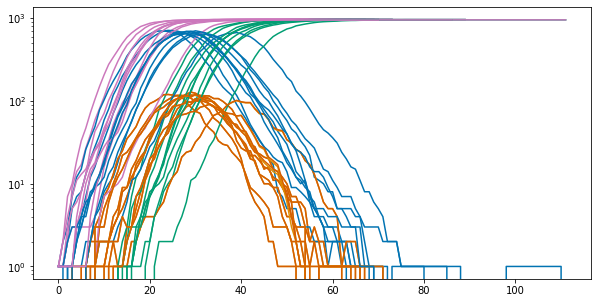

In [33]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "is_quarantined", "is_recovered", "is_symptomatic", "was_infected"]
for stats in results:
    for field, color in zip(fields, colors):
        plt.plot(stats[0][field], color=color, label=field)
plt.semilogy()

In [24]:
contagion = Contagion(my_config)


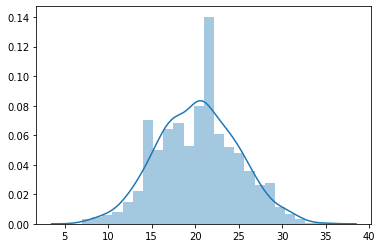

In [25]:
degree_dist = list(dict(contagion.pop._graph.degree).values())
sns.distplot(degree_dist)

In [21]:
contagion.pop._graph.remove_edges_from()

EdgeView([(0, 1), (0, 3), (0, 7), (0, 8), (0, 9), (0, 12), (0, 14), (0, 16), (0, 17), (0, 18), (0, 19), (0, 23), (0, 26), (0, 27), (0, 29), (0, 893), (0, 434), (0, 819), (0, 716), (0, 201), (0, 46), (0, 182), (0, 333), (0, 529), (0, 437), (0, 700), (0, 100), (0, 848), (0, 543), (0, 550), (0, 58), (0, 435), (0, 988), (0, 87), (0, 277), (0, 905), (1, 3), (1, 4), (1, 5), (1, 8), (1, 9), (1, 10), (1, 13), (1, 16), (1, 19), (1, 23), (1, 27), (1, 28), (1, 29), (1, 671), (1, 370), (1, 440), (1, 901), (1, 622), (1, 886), (1, 902), (1, 907), (1, 662), (1, 336), (1, 330), (1, 691), (1, 236), (1, 463), (1, 167), (1, 477), (1, 874), (1, 570), (1, 57), (1, 183), (1, 256), (1, 337), (1, 404), (1, 631), (1, 699), (1, 912), (2, 4), (2, 6), (2, 12), (2, 14), (2, 15), (2, 16), (2, 18), (2, 20), (2, 23), (2, 24), (2, 26), (2, 29), (2, 695), (2, 451), (2, 91), (2, 603), (2, 10), (2, 693), (2, 946), (2, 971), (2, 379), (2, 108), (2, 316), (2, 905), (2, 596), (2, 17), (2, 393), (2, 916), (2, 821), (2, 418),